In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
train = pd.read_csv("/content/train_u6lujuX_CVtuZ9i.csv")
test = pd.read_csv("/content/test_Y3wMUE5_7gLdaTN.csv")

Data Preprocessing

In [4]:
train['source'] = 'train'
test['source'] = 'test'
data = pd.concat([train, test], ignore_index=True)


In [5]:
# Fill categorical columns with mode
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History', 'Loan_Amount_Term']:
    data[col].fillna(data[col].mode()[0], inplace=True)

# Fill numeric column
data['LoanAmount'].fillna(data['LoanAmount'].median(), inplace=True)


<ipython-input-5-c4a10fd80238>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mode()[0], inplace=True)
<ipython-input-5-c4a10fd80238>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

In [6]:
le = LabelEncoder()
for col in ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Dependents']:
    data[col] = le.fit_transform(data[col])


In [7]:
# Drop columns not needed
data.drop(['Loan_ID'], axis=1, inplace=True)

# Split data back
train_data = data[data['source'] == 'train'].drop(['source'], axis=1)
test_data = data[data['source'] == 'test'].drop(['source', 'Loan_Status'], axis=1)

# Encode target
train_data['Loan_Status'] = le.fit_transform(train_data['Loan_Status'])

# Define X and y
X = train_data.drop('Loan_Status', axis=1)
y = train_data['Loan_Status']

# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [9]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)


GradientBoostingClassifier(random_state=42)

In [10]:
vc = VotingClassifier(estimators=[
    ('rf', rf),
    ('gb', gb)
], voting='soft')

vc.fit(X_train, y_train)


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(random_state=42))],
                 voting='soft')

Evaluate the Models
python
Copy
Edit


In [11]:
for model, name in zip([rf, gb, vc], ['Random Forest', 'Gradient Boosting', 'Voting Classifier']):
    y_pred = model.predict(X_val)
    print(f"\n{name} Accuracy: {accuracy_score(y_val, y_pred):.4f}")
    print(classification_report(y_val, y_pred))



Random Forest Accuracy: 0.7561
              precision    recall  f1-score   support

           0       0.78      0.42      0.55        43
           1       0.75      0.94      0.83        80

    accuracy                           0.76       123
   macro avg       0.77      0.68      0.69       123
weighted avg       0.76      0.76      0.73       123


Gradient Boosting Accuracy: 0.7398
              precision    recall  f1-score   support

           0       0.72      0.42      0.53        43
           1       0.74      0.91      0.82        80

    accuracy                           0.74       123
   macro avg       0.73      0.67      0.67       123
weighted avg       0.74      0.74      0.72       123


Voting Classifier Accuracy: 0.7642
              precision    recall  f1-score   support

           0       0.82      0.42      0.55        43
           1       0.75      0.95      0.84        80

    accuracy                           0.76       123
   macro avg       0.79 

Predict on Test Set and Save

In [12]:
test_predictions = vc.predict(test_data)
submission = pd.read_csv("test_Y3wMUE5_7gLdaTN.csv")
submission['Loan_Status'] = le.inverse_transform(test_predictions)
submission[['Loan_ID', 'Loan_Status']].to_csv("submission.csv", index=False)


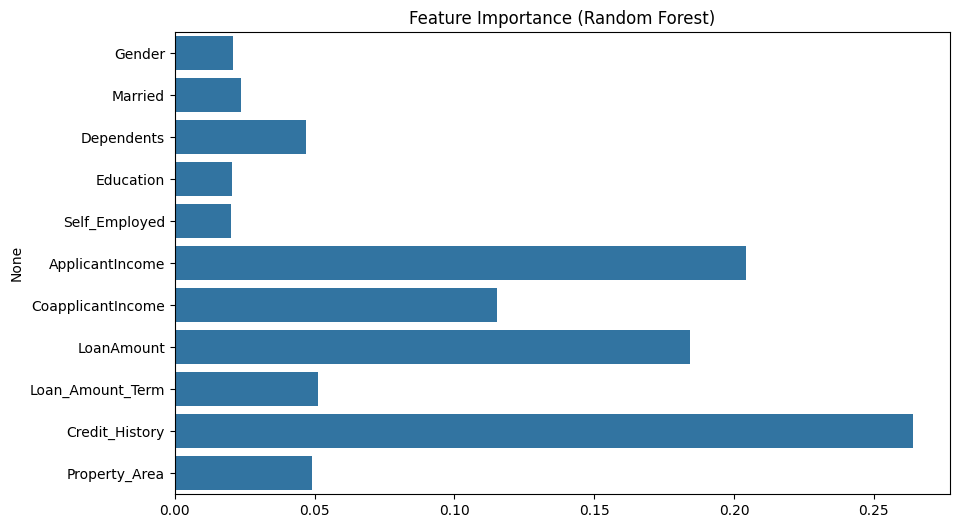

In [13]:
importances = rf.feature_importances_
feat_names = X.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=feat_names)
plt.title("Feature Importance (Random Forest)")
plt.show()
